In [558]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from numpy import array

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/google-stock/google_stock - Sheet1.csv


In [559]:
# Using a dtaframe to store the data

df = pd.read_csv('/kaggle/input/google-stock/google_stock - Sheet1.csv')

In [560]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3214 non-null   object 
 1   Open    3214 non-null   float64
 2   High    3214 non-null   float64
 3   Low     3214 non-null   float64
 4   Close   3214 non-null   float64
 5   Volume  3214 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 150.8+ KB


In [561]:
df.head(10)

,Date,Open,High,Low,Close,Volume
0,1/3/2012 16:00:00,16.31,16.70,16.31,16.64,3677850
1,1/4/2012 16:00:00,16.63,16.76,16.52,16.71,2864365
2,1/5/2012 16:00:00,16.54,16.60,16.41,16.48,3283277
3,1/6/2012 16:00:00,16.48,16.50,16.24,16.25,2694024
4,1/9/2012 16:00:00,16.16,16.18,15.53,15.56,5825720
5,1/10/2012 16:00:00,15.74,15.85,15.42,15.58,4395615
6,1/11/2012 16:00:00,15.59,15.73,15.53,15.65,2400582
7,1/12/2012 16:00:00,15.78,15.82,15.66,15.74,1875854
8,1/13/2012 16:00:00,15.66,15.67,15.53,15.62,2307338
9,1/17/2012 16:00:00,15.80,15.80,15.64,15.71,1909394


In [562]:
df1 = df.reset_index()['Close']

In [563]:
df1

0        16.64
1        16.71
2        16.48
3        16.25
4        15.56
         ...  
3209    167.06
3210    162.98
3211    164.38
3212    161.86
3213    162.08
Name: Close, Length: 3214, dtype: float64

In [564]:
df1.shape

(3214,)

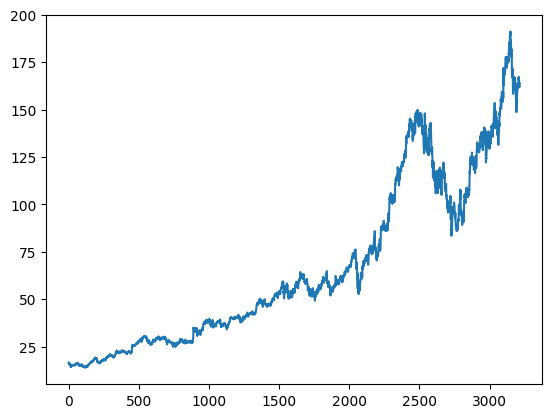

In [565]:
# Plotting the closing price of the stocks over the years

plt.plot(df1)
plt.xlabel("Days")
plt.ylabel("Stock Closing Price")
plt.show()

In [566]:
df1.shape

(3214,)

In [567]:
df1 = np.array(df1).reshape(-1, 1)

In [568]:
df1.shape

(3214, 1)

In [569]:
# Splitting the data into training, validation and testing data

length = int(len(df1) * 0.6)
val_length = int((len(df1) - length) / 2)
train_data = df1[:length, :]
val_data = df1[length:length + val_length, :]
test_data = df1[length + val_length:, :]

In [570]:
print(train_data.shape, val_data.shape, test_data.shape)

(1928, 1) (643, 1) (643, 1)


In [571]:
# Using MinMaxScaler to scale to make ensure an efficient model training

scaler = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = scaler.fit_transform(np.array(train_data))
val_data_scaled = scaler.fit_transform(np.array(val_data))
test_data_scaled = scaler.fit_transform(np.array(test_data))

In [572]:
train_data_scaled

array([[0.0523313 ],
       [0.05370844],
       [0.04918355],
       ...,
       [0.87959866],
       [0.89966555],
       [0.89612434]])

In [573]:
train_data_scaled.shape
train_data_scaled

array([[0.0523313 ],
       [0.05370844],
       [0.04918355],
       ...,
       [0.87959866],
       [0.89966555],
       [0.89612434]])

In [574]:
# Function to create data based on the window specified

def create_dataset(dataset, window = 1):
    X_data, y_data = [], []
    for i in range(len(dataset) - window - 1):
        x = dataset[i : (i+window), 0]
        X_data.append(x)
        y_data.append(dataset[i + window, 0])
    return np.array(X_data), np.array(y_data)

In [575]:
# We use window to make specify the dapendence of the current price on the past prices

window = 75
X_train, y_train = create_dataset(train_data_scaled, window)
X_val, y_val = create_dataset(val_data_scaled, window)
X_test, y_test = create_dataset(test_data_scaled, window)

In [576]:
print(y_train)

[0.01809955 0.01888648 0.02065709 ... 0.87664765 0.87959866 0.89966555]


In [577]:
# Reshaping the data so that it can be passed into the model

_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [578]:
X_train.shape

(1852, 75, 1)

In [579]:
# Creating and compiling a LSTM model

model = keras.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape = (75, 1)),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam',
             loss = 'mean_squared_error')

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_45 (LSTM)                  │ (None, 75, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 75, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [580]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, batch_size = 64, verbose = 1)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0845 - val_loss: 0.0040
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5182e-04 - val_loss: 0.0025
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8773e-04 - val_loss: 0.0023
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.8622e-04 - val_loss: 0.0024
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.8683e-04 - val_loss: 0.0024
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.8885e-04 - val_loss: 0.0027
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.4349e-04 - val_loss: 0.0022
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.5868e-04 - val_loss: 0.0021
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.9661e-04 - val_loss: 0.0024
Epoch 12/50
29/29 ━━━━━━━━━━━━━

In [581]:
# Calculating the predicted values

train_prediction = model.predict(X_train)
val_prediction = model.predict(X_val)
test_prediction = model.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [582]:
# Claculating the Root Mean Squared Error metric for train data

math.sqrt(mean_squared_error(y_train, train_prediction))

0.020879447361182073

In [583]:
# Claculating the Root Mean Squared Error metric for validation data

math.sqrt(mean_squared_error(y_val, val_prediction))

0.03382760718577852

In [584]:
# Claculating the Root Mean Squared Error metric for test data

math.sqrt(mean_squared_error(y_test, test_prediction))

0.041667916543303846

In [585]:
# Performing the inverse scaler transform in the predicted data

train_prediction = scaler.inverse_transform(train_prediction)
val_prediction = scaler.inverse_transform(val_prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [586]:
print(train_prediction.shape, val_prediction.shape, test_prediction.shape)

(1852, 1) (567, 1) (567, 1)


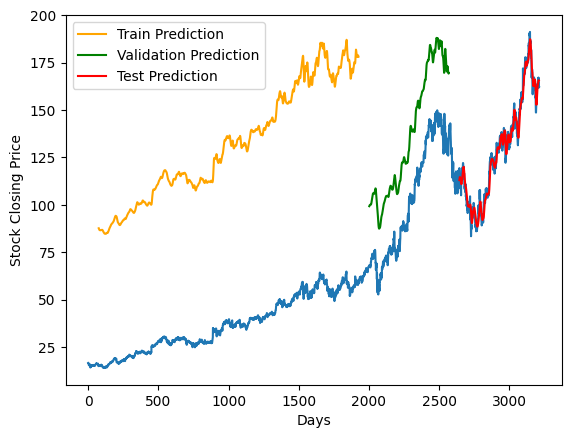

In [587]:
# Plotting the predicted values and the actual values in a graph

# PLotting the predicted train data values
look_back = 75
train_plot = np.empty_like(df1)
train_plot[:, :] = np.nan
train_plot[look_back : len(train_prediction) + look_back, :] = train_prediction

# PLotting the predicted validation data values
val_plot = np.empty_like(df1)
val_plot[:, :] = np.nan
start_idx = len(train_prediction) + (look_back * 2) + 1
end_idx = start_idx + len(val_prediction)
val_plot[start_idx:end_idx, :] = val_prediction

# PLotting the predicted test data values
test_plot = np.empty_like(df1)
test_plot[:, :] = np.nan
start_idx_test = end_idx + (look_back * 1)
end_idx_test = start_idx_test + len(test_prediction)
test_plot[start_idx_test:end_idx_test, :] = test_prediction

# Plotting the original values
# plt.plot(scaler.inverse_transform(df1))
plt.plot(df1)
plt.plot(train_plot, label = 'Train Prediction', color = 'orange')
plt.plot(val_plot, label = 'Validation Prediction', color = 'green')
plt.plot(test_plot, label = 'Test Prediction', color = 'red')
plt.xlabel("Days")
plt.ylabel("Stock Closing Price")
plt.legend()
plt.show()

In [588]:
len(test_data)

643

In [589]:
X_input = test_data_scaled[543:].reshape(1, -1)
X_input.shape

(1, 100)

In [590]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [591]:
len(temp_input)

100

In [592]:
# Predicting the output for the next 30 days

list_output = []
steps = 100
initial = 0
while(initial < 30):
    if(len(temp_input) > 100):
        X_input = np.array(temp_input[1 : ])
#         print("{} input {}".format(initial, X_input))
        X_input = X_input.reshape(1, -1)
        X_input = X_input.reshape((1, steps, 1))
        y_pred = model.predict(X_input, verbose = 0)
#         print("{} input {}".format(initial, y_pred))
        temp_input.extend(y_pred[0].tolist())
        temp_input = temp_input[1 : ]
        list_output.extend(y_pred.tolist())
        initial += 1
    else:
        X_input = X_input.reshape((1, steps, 1))
        y_pred = model.predict(X_input, verbose = 0)
#         print(y_pred[0])
        temp_input.extend(y_pred[0].tolist())
#         print(len(temp_input))
        list_output.extend(y_pred.tolist())
        initial += 1
        
print(list_output)

[[0.7531876564025879], [0.7487879991531372], [0.7458564639091492], [0.7442095875740051], [0.7435058951377869], [0.7434239387512207], [0.743722677230835], [0.7442437410354614], [0.7448927164077759], [0.7456163167953491], [0.7463851571083069], [0.74718177318573], [0.747994065284729], [0.7488126754760742], [0.7496293187141418], [0.7504369020462036], [0.7512295246124268], [0.7520026564598083], [0.7527536153793335], [0.7534805536270142], [0.7541829347610474], [0.7548613548278809], [0.7555168271064758], [0.7561511397361755], [0.7567662596702576], [0.7573643922805786], [0.7579476237297058], [0.7585181593894958], [0.7590780258178711], [0.7596290707588196]]


In [593]:
# list_output

In [594]:
cur = np.arange(1, 101)
nxt = np.arange(101, 131)

In [595]:
df2 = df1.tolist()
df2.extend(scaler.inverse_transform(list_output))

In [596]:
len(df1)

3214

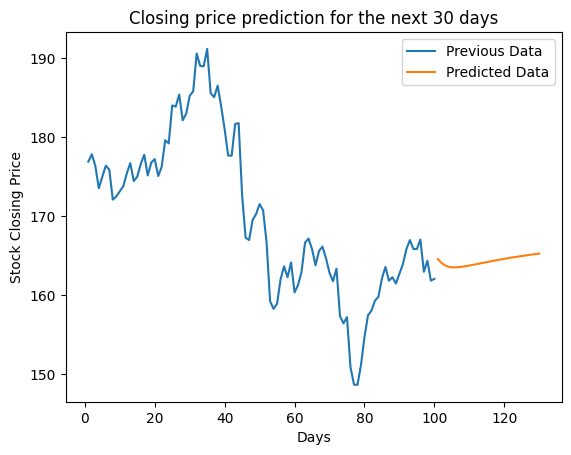

In [599]:
# Plotting the predicted prices seperately

plt.plot(cur, df1[3114:], label = 'Previous Data')
plt.plot(nxt, scaler.inverse_transform(list_output), label = 'Predicted Data')
plt.xlabel("Days")
plt.ylabel("Stock Closing Price")
plt.title("Closing price prediction for the next 30 days")
plt.legend()
plt.show()

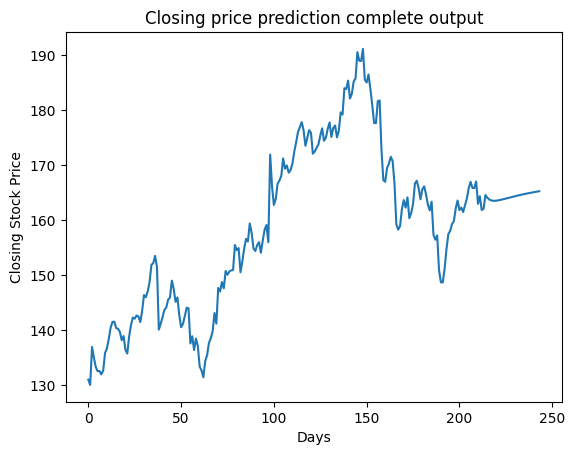

In [600]:
# Predicting the prices by adding them into the existing data

plt.plot(df2[3000:])
plt.xlabel("Days")
plt.ylabel("Closing Stock Price")
plt.title("Closing price prediction complete output")
plt.show()